In [1]:
import sys, os
parent_dir = os.getcwd()
path = os.path.dirname(parent_dir)
sys.path.append(path)

from gym_homer.envs.homer_env import HomerEnv
import pandas as pd
import numpy as np

import torch
import gym
from gym import spaces, wrappers
import envpool

from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer, AsyncCollector, PrioritizedVectorReplayBuffer
from tianshou.env import DummyVectorEnv, SubprocVectorEnv, ShmemVectorEnv
from tianshou.policy import PPOPolicy
from tianshou.trainer import onpolicy_trainer
from tianshou.utils.net.common import ActorCritic, Net
from tianshou.utils.net.discrete import Actor, Critic

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
i=0

In [2]:
path

'/home/ds1/w210/home-energy-optimizer'

In [3]:
log_path = path+'/logs/'
logger = WandbLogger(
    project="RL_project", 
    entity="w266_wra",
    name=f'debug_{i}',
    config=None)
logger.load(SummaryWriter(log_path))
i += 1

wandb: Currently logged in as: atox120 (w266_wra). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /home/ds1/w210/home-energy-optimizer/logs/


In [4]:
# Load Data
data = pd.read_csv(path+"/test_env_data.csv", index_col=False).fillna(0)
vectorised = False


n_train_envs = 10
n_test_envs = 10

env = HomerEnv(data=data, start_soc='full')
train_envs = SubprocVectorEnv([lambda: HomerEnv(
    data=data, 
    capacity=10,
    start_soc='full', 
    discrete=True,
    charge_rate = 12) for _ in range(n_train_envs)])

test_envs = SubprocVectorEnv([lambda: HomerEnv(
    data=data, 
    capacity=10,
    start_soc='full', 
    discrete=True,
    charge_rate = 12,
    save_history=True,
    save_path=path) for _ in range(n_test_envs)])

In [5]:
data

,time_x,time_y,weekend,month_x,month_y,region_1,region_2,region_3,solar,loads,import_tariff,export_tariff,max_d,max_c,soc
0,0.000,1.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
1,0.500,0.866,0,0.0,1.0,0,0,0,-2,0.5,0.05,0.0,0.0,0.0,0.0
2,0.866,0.500,0,0.0,1.0,0,0,0,-2,0.5,0.05,0.0,0.0,0.0,0.0
3,1.000,0.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
4,0.866,-0.500,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
5,0.500,-0.866,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
6,0.000,-1.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0
7,-0.500,-0.866,0,0.0,1.0,0,0,0,0,0.5,2.00,2.0,0.0,0.0,0.0
8,-0.866,-0.500,0,0.0,1.0,0,0,0,0,0.5,2.00,2.0,0.0,0.0,0.0
9,-1.000,-0.000,0,0.0,1.0,0,0,0,0,0.5,0.05,0.0,0.0,0.0,0.0


In [6]:
env.observation_space.shape

(15,)

In [7]:
# net is the shared head of the actor and the critic
hidden_sizes = [64,64]
lr_optimizer = 1e-4

net = Net(
    env.observation_space.shape, 
    hidden_sizes=hidden_sizes, 
    device=device
    )

actor = Actor(net, 3, device=device).to(device)
#actor = Actor(net, env.action_space.n, device=device).to(device)

critic = Critic(net, device=device).to(device)
actor_critic = ActorCritic(actor, critic)

# optimizer of the actor and the critic
optim = torch.optim.Adam(actor_critic.parameters(), lr=lr_optimizer)

In [8]:
print(env.action_space)

Discrete(3)


In [9]:
# Since environment action space is discrete 
dist = torch.distributions.Categorical
policy = PPOPolicy(
    actor, 
    critic, 
    optim, 
    dist, 
    action_space=env.action_space, 
    deterministic_eval=True
)

In [10]:
n_steps = 5000
n_max_epochs = 20
rep_per_collector = 10
eps_per_test = 10
batch_size = 256
n_steps_per_collect = 2000
reward_stop = 4


In [11]:
buffer_train = PrioritizedVectorReplayBuffer(total_size = 10000, buffer_num = len(train_envs), alpha=0.8, beta=0.5, ignore_obs_next=True)
train_collector = Collector(policy, train_envs, buffer_train)
test_collector = Collector(policy, test_envs)

output = train_collector.collect(
    n_step=batch_size * 2880
)
print(len(buffer_train))

10000


We have the Vector Replay Buffer, with:

- total_size = the total size of VectorReplayBuffer. = 10,000 = len(buffer_train)
- buffer_num (the number of ReplayBuffer's it uses,) = len(train_envs) = 10

Basically, the buffer will contain as many steps as total_size. 
buffer_num is the number of parallel buffer objects to create. 
Each of these vectorised buffers will be of length=int(np.ceil(total_size / buffer_num)). 

With n_step in the collector = batch_size * 288 = 7328

note for the collector:
- n/ep = 6700 = 256 * 288 / 11 (batch size * 288 / 11)
- n/st = 7370 = n/ep * 11

In [54]:
output

{'n/ep': 67020,
 'n/st': 737280,
 'rews': array([ 1.775     , -0.15      , -0.15      , ..., -2.23055556,
        -2.2       ,  1.725     ]),
 'lens': array([11, 11, 11, ..., 11, 11, 11]),
 'idxs': array([   0, 1000, 2000, ..., 7711, 8711, 9711]),
 'rew': -1.439542464006227,
 'len': 11.0,
 'rew_std': 2.0833047855094864,
 'len_std': 0.0}

In [50]:
len(buffer_train.act)

10000

In [45]:
unique, counts = np.unique(buffer_train.act, return_counts=True)
[print(f"Action: {unique[i]:.4f}, Counts: {counts[i]}") for i in range(len(unique))]

Action: 0.0000: 3989
Action: 1.0000: 3006
Action: 2.0000: 3005


[None, None, None]

In [31]:
a = {"a1":[1], 'a2':[2]}
b = {"b1":[1], 'b2':[2]}

In [35]:
c = a | b

In [37]:
c.keys()

dict_keys(['a1', 'a2', 'b1', 'b2'])

In [16]:
buffer_train
#len(buffer_train.info.reward)

PrioritizedVectorReplayBuffer(
    act: array([0, 0, 2, ..., 2, 0, 1]),
    info: Batch(
              net: array([-0.5, -0.5,  1.5, ..., -0.5, -0.5,  0.5]),
              cumulative_reward: array([-0.025, -0.025, -3.025, ..., -0.025, -0.025, -0.05 ]),
              bat_output: array([-1., -1.,  1., ...,  1., -1.,  0.]),
              tick: array([5, 6, 7, ..., 2, 3, 4]),
              action: array([0, 0, 2, ..., 2, 0, 1]),
              reward: array([ 0.   ,  0.   , -3.   , ...,  0.   ,  0.   , -0.025]),
              env_id: array([0, 0, 0, ..., 9, 9, 9]),
              updated_action: array([-1., -1.,  1., ...,  1., -1.,  0.]),
          ),
    terminated: array([False, False, False, ..., False, False, False]),
    truncated: array([False, False, False, ..., False, False, False]),
    done: array([False, False, False, ..., False, False, False]),
    policy: Batch(),
    rew: array([ 0.   ,  0.   , -3.   , ...,  0.   ,  0.   , -0.025]),
    obs: array([[ 0.866     , -0.5       ,  0

In [23]:
buffer_train.obs.shape

(10000, 15)

In [40]:
len(buffer_train.info.reward)

100000000

(array([ 2771.,   646., 10325.,    44., 19930.,  5346.,   698., 17187.,
            0., 10073.]),
 array([-6.27777778, -5.45      , -4.62222223, -3.79444445, -2.96666667,
        -2.13888889, -1.31111111, -0.48333333,  0.34444444,  1.17222222,
         2.        ]),
 <BarContainer object of 10 artists>)

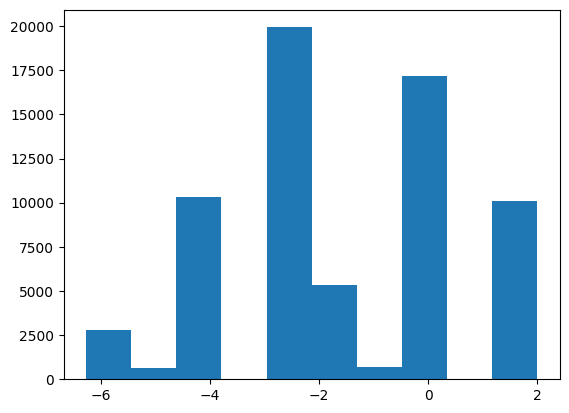

In [31]:
import matplotlib.pyplot as plt
plt.hist(output['rews'])

In [36]:
buffer_train.act

array([1, 1, 0, 1, 2, 1, 2, 2, 0, 1])

In [48]:
result = onpolicy_trainer(
    policy,
    train_collector,
    test_collector,
    max_epoch=n_max_epochs,
    step_per_epoch=n_steps,
    repeat_per_collect=rep_per_collector,
    episode_per_test=eps_per_test,
    batch_size=batch_size,
    step_per_collect= n_steps_per_collect,
    stop_fn=lambda mean_reward: mean_reward >= reward_stop,
    logger=logger,
    verbose=True
    )

Epoch #1: 6000it [00:00, 11275.15it/s, env_step=6000, len=11, loss=0.703, loss/clip=-0.004, loss/ent=1.096, loss/vf=1.436, n/ep=180, n/st=2000, rew=-1.74]                           


Epoch #1: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #2: 6000it [00:00, 11023.99it/s, env_step=12000, len=11, loss=0.347, loss/clip=-0.003, loss/ent=1.096, loss/vf=0.723, n/ep=180, n/st=2000, rew=-1.42]                          


Epoch #2: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #3: 6000it [00:00, 11462.86it/s, env_step=18000, len=11, loss=0.379, loss/clip=-0.004, loss/ent=1.094, loss/vf=0.788, n/ep=180, n/st=2000, rew=-1.65]                          


Epoch #3: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #4: 6000it [00:00, 11845.58it/s, env_step=24000, len=11, loss=0.257, loss/clip=-0.005, loss/ent=1.091, loss/vf=0.546, n/ep=180, n/st=2000, rew=-1.40]                          


Epoch #4: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #5: 6000it [00:00, 11487.70it/s, env_step=30000, len=11, loss=0.349, loss/clip=-0.005, loss/ent=1.085, loss/vf=0.729, n/ep=190, n/st=2000, rew=-1.41]                          


Epoch #5: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #6: 6000it [00:00, 11522.14it/s, env_step=36000, len=11, loss=0.211, loss/clip=-0.005, loss/ent=1.076, loss/vf=0.454, n/ep=180, n/st=2000, rew=-0.93]                          


Epoch #6: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #7: 6000it [00:00, 11729.50it/s, env_step=42000, len=11, loss=0.367, loss/clip=-0.006, loss/ent=1.064, loss/vf=0.767, n/ep=190, n/st=2000, rew=-0.94]                          


Epoch #7: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #8: 6000it [00:00, 11554.85it/s, env_step=48000, len=11, loss=0.205, loss/clip=-0.006, loss/ent=1.046, loss/vf=0.444, n/ep=180, n/st=2000, rew=-0.61]                          


Epoch #8: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #9: 6000it [00:00, 11901.74it/s, env_step=54000, len=11, loss=0.232, loss/clip=-0.009, loss/ent=1.017, loss/vf=0.503, n/ep=180, n/st=2000, rew=-0.39]                          


Epoch #9: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #10: 6000it [00:00, 11334.01it/s, env_step=60000, len=11, loss=0.176, loss/clip=-0.009, loss/ent=0.976, loss/vf=0.388, n/ep=180, n/st=2000, rew=0.08]                           


Epoch #10: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #11: 6000it [00:00, 10973.27it/s, env_step=66000, len=11, loss=0.175, loss/clip=-0.009, loss/ent=0.926, loss/vf=0.388, n/ep=180, n/st=2000, rew=0.34]                          


Epoch #11: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #12: 6000it [00:00, 9943.49it/s, env_step=72000, len=11, loss=0.153, loss/clip=-0.009, loss/ent=0.850, loss/vf=0.341, n/ep=180, n/st=2000, rew=0.67]                           


Epoch #12: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #13: 6000it [00:00, 10235.41it/s, env_step=78000, len=11, loss=0.152, loss/clip=-0.010, loss/ent=0.782, loss/vf=0.341, n/ep=180, n/st=2000, rew=0.79]                          


Epoch #13: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #14: 6000it [00:00, 9612.20it/s, env_step=84000, len=11, loss=0.155, loss/clip=-0.011, loss/ent=0.682, loss/vf=0.345, n/ep=180, n/st=2000, rew=1.31]                          


Epoch #14: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #15: 6000it [00:00, 11582.20it/s, env_step=90000, len=11, loss=0.111, loss/clip=-0.010, loss/ent=0.597, loss/vf=0.254, n/ep=180, n/st=2000, rew=1.19]                          


Epoch #15: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #16: 6000it [00:00, 10134.60it/s, env_step=96000, len=11, loss=0.201, loss/clip=-0.009, loss/ent=0.508, loss/vf=0.429, n/ep=190, n/st=2000, rew=1.68]                          


Epoch #16: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #17: 6000it [00:00, 9922.93it/s, env_step=102000, len=11, loss=0.104, loss/clip=-0.006, loss/ent=0.440, loss/vf=0.228, n/ep=180, n/st=2000, rew=1.32]                           


Epoch #17: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #18: 6000it [00:00, 10355.25it/s, env_step=108000, len=11, loss=0.226, loss/clip=-0.006, loss/ent=0.377, loss/vf=0.472, n/ep=190, n/st=2000, rew=1.74]                          


Epoch #18: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #19: 6000it [00:00, 10709.18it/s, env_step=114000, len=11, loss=0.186, loss/clip=-0.004, loss/ent=0.326, loss/vf=0.386, n/ep=180, n/st=2000, rew=1.72]                          


Epoch #19: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


Epoch #20: 6000it [00:00, 11106.35it/s, env_step=120000, len=11, loss=0.212, loss/clip=-0.003, loss/ent=0.281, loss/vf=0.434, n/ep=180, n/st=2000, rew=1.72]                          


Epoch #20: test_reward: 1.974342 ± 0.000000, best_reward: 1.974342 ± 0.000000 in #0


In [32]:
# Let's watch its performance!
policy.eval()
result = test_collector.collect(n_episode=1, render=False)
print("Final reward: {}, length: {}".format(result["rews"].mean(), result["lens"].mean()))

Final reward: 2.0, length: 11.0


In [26]:
print(result)

{'n/ep': 1, 'n/st': 11, 'rews': array([2.]), 'lens': array([11]), 'idxs': array([0]), 'rew': 2.0, 'len': 11.0, 'rew_std': 0.0, 'len_std': 0.0}


In [27]:
## Not in dcs - also not sure if required. 
logger.wandb_run.finish()